# I - Importations

In [1]:
import os
import numpy as np
from collections import namedtuple
import tensorflow as tf
from tensorflow.keras import models # type: ignore
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, concatenate, Input, MaxPooling2D # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.utils import Sequence # type: ignore
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore
from tensorflow.keras.applications import VGG16 # type: ignore
import albumentations as Album

import mlflow
import mlflow.tensorflow

from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# II - Paramétrages

In [2]:
TRAIN_IMAGE_DIR = "datas/train/image"
TRAIN_MASK_DIR = "datas/train/labelIds"
VAL_IMAGE_DIR = "datas/val/image"
VAL_MASK_DIR = "datas/val/labelIds"
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
LIMIT_NUM_IMAGES = None

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("experiment")
mlflow.tensorflow.autolog()

2024/10/31 16:52:35 WARNING mlflow.utils.autologging_utils: MLflow tensorflow autologging is known to be compatible with 2.7.4 <= tensorflow <= 2.17.0, but the installed version is 2.18.0. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a compatible version, or try upgrading MLflow.


# III - Classes

In [3]:
class ImageMaskGenerator(Sequence):
    """
    Classe pour générer des lots (batches) d'images et de masques segmentés pour l'entraînement de modèles.
    """

    def __init__(self, image_dir, mask_dir, class_mapping, batch_size=32, img_height=1024, img_width=2048, shuffle=True, limit_num_images=None, augment=False, **kwargs):
        """
        Initialise le générateur avec les répertoires d'images et de masques, les paramètres d'entraînement, et les options d'augmentation et de mélange des données.
        """
        # Dossiers contenant les images et les masques
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        
        # Dictionnaire pour mapper les classes du masque à des valeurs uniques
        self.class_mapping = class_mapping

        # Paramètres pour la génération des lots
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.limit_num_images = limit_num_images  # Limite le nombre d'images utilisées (si défini pour essayer la classe)
        self.augment = augment  # Précise si l'augmentation des données doit être utilisé
        self.shuffle = shuffle  # Précise si le mélange des données doit être utilisé

        # Liste des paires (image, masque) pour les données d'entraînement
        self.image_mask_pairs = self.create_image_mask_pairs()
        
        # Liste d'index pour les données, utilisée pour le mélange
        self.indexes = np.arange(len(self.image_mask_pairs))

        # Pipeline d'augmentations des données avec Albumentations (appliqué si augment est True)
        self.augmentation_pipeline = Album.Compose([
            Album.HorizontalFlip(p=0.5),
            Album.RandomBrightnessContrast(p=0.2),
            Album.Rotate(limit=35, p=0.5)
        ])

        # Appel à on_epoch_end pour initialiser le mélange des données au début
        self.on_epoch_end()
        
        super().__init__(**kwargs)

    def __len__(self):
        """
        Retourne le nombre de lots par époque.
        """
        return int(np.ceil(len(self.image_mask_pairs) / self.batch_size))

    def __getitem__(self, idx):
        """
        Génère un lot d'images et de masques pour un index donné.
        """
        # Sélection des index pour le lot actuel
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Génération des données du lot
        batch_images, batch_masks = self.__data_generation(batch_indexes)
        
        return batch_images, batch_masks

    def __data_generation(self, batch_indexes):
        """
        Génère les données (images et masques) pour les index donnés.
        """
        images = []
        masks = []

        # Paires image-masque pour le lot actuel
        batch_image_mask_pairs = [self.image_mask_pairs[i] for i in batch_indexes]
        
        for image_name, mask_name in batch_image_mask_pairs:
            # Chemins complets pour l'image et le masque
            image_path = os.path.join(self.image_dir, image_name)
            mask_path = os.path.join(self.mask_dir, mask_name)

            # Chargement de l'image
            img = img_to_array(load_img(image_path, target_size=(self.img_height, self.img_width)), dtype=np.float32)

            # Chargement du masque
            mask = img_to_array(load_img(mask_path, target_size=(self.img_height, self.img_width)), dtype=np.float32)
            mask = mask[..., 0]  # On conserve seulement la première couche pour le masque car l'id label est identique pour toutes les couches
            
            # Augmentation de l'image et du masque si self.augment est activé
            if self.augment:
                augmented = self.augmentation_pipeline(image=img, mask=mask)
                img, mask = augmented["image"], augmented["mask"]

            # Initialisation d'un masque vide avec les dimensions (hauteur, largeur, nombre de classes)
            mapped_mask = np.zeros((self.img_height, self.img_width, 8), dtype=np.int8)
            
            # Mapping des valeurs du masque d'origine vers les classes définies dans class_mapping
            for val, mapped_val in self.class_mapping.items():
                mapped_mask[mask == val, mapped_val] = 1

            # Normalisation de l'image et ajout à la liste d'images et de masques
            images.append(img / 255.0)
            masks.append(mapped_mask)

        # Retourne les tableaux numpy des images et des masques pour le lot
        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.int8)

    def on_epoch_end(self):
        """
        Mélange les index des données à la fin de chaque époque si shuffle est activé.
        """
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def create_image_mask_pairs(self):
        """
        Crée des paires (image, masque) basées sur les fichiers disponibles dans les dossiers
        image_dir et mask_dir. Limite le nombre si limit_num_images est défini.
        """
        if self.limit_num_images:
            image_files = [f for i, f in enumerate(os.listdir(self.image_dir)) if i < self.limit_num_images]
            mask_files = [f for i, f in enumerate(os.listdir(self.mask_dir)) if i < self.limit_num_images]
        else:
            image_files = [f for f in os.listdir(self.image_dir)]
            mask_files = [f for f in os.listdir(self.mask_dir)]

        # Retourne une liste de tuples (image, masque)
        return list(zip(image_files, mask_files))


# IV - Fonctions

In [4]:
# Ce n'est pas du tout mon code, c'est du copié collé depuis le github : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
# Le namedTuple a pour but de pouvoir récupérer les informations de cityscrape

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [5]:
def count_classes_in_masks(mask_dir, num_classes):
    """
    Récupère toutes les images masque d'un dossier et calcule le nombre total de chaque classe.

    Args:
        mask_dir (str): Le chemin vers le répertoire contenant les masques.
        num_classes (int): Le nombre total de classes à compter.

    Returns:
        dict: Un dictionnaire avec le nombre total de pixels pour chaque classe.
    """
    # Initialiser un compteur pour chaque classe
    class_counts = {i: 0 for i in range(num_classes)}
    
    # Parcourir chaque fichier dans le répertoire des masques
    for mask_file in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_file)
        
        # Charger le masque et convertir en tableau numpy
        mask = np.array(Image.open(mask_path))
        
        # Compter les pixels pour chaque classe
        for i in range(num_classes):
            class_counts[i] += np.sum(mask == i)

    return class_counts

In [6]:
def unet_mini(input_shape):
    inputs = Input(shape=input_shape)

    # Partie contraction des images 
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Entraînement de reconnaissance des paterns
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    # Partie expansion des images à la dimension définie
    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(8, (1, 1), activation='softmax')(c5)# 8 classes

    # Construction du modèle
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [7]:
def unet_vgg16(input_shape=(128, 128, 3), num_classes=8):
    # Encodeur: partie non entraînable de VGG16 pré-entrainé sur imagenet
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    # Extract specific feature layers for skip connections in the U-Net architecture
    f1 = base_model.get_layer("block1_pool").output  # (64x64)
    f2 = base_model.get_layer("block2_pool").output  # (32x32)
    f3 = base_model.get_layer("block3_pool").output  # (16x16)
    f4 = base_model.get_layer("block4_pool").output  # (8x8)
    f5 = base_model.get_layer("block5_pool").output  # (4x4)
    
    # Decodeur: U-Net style upsampling with skip connections
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(f5)
    up6 = concatenate([up6, f4])  # Skip connection
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, f3])  # Skip connection
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, f2])  # Skip connection
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, f1])  # Skip connection
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    
    # Final upsampling layer
    up10 = UpSampling2D((2, 2))(conv9)
    output = Conv2D(num_classes, (1, 1), activation='softmax')(up10)
    
    # Model
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

In [8]:
import tensorflow as tf

def dice_loss_multiclass(y_true, y_pred, smooth=1e-6):
    # Séparer les classes
    dice_losses = []
    for i in range(y_pred.shape[-1]):  # Pour chaque classe
        y_true_f = tf.keras.backend.flatten(y_true[..., i])
        y_pred_f = tf.keras.backend.flatten(y_pred[..., i])
        
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        dice_coef = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
        
        dice_losses.append(1 - dice_coef)  # Dice Loss pour chaque classe

    return tf.reduce_mean(dice_losses)  # Moyenne de la Dice Loss sur toutes les classes


In [9]:
def total_loss(y_true, y_pred):
    # Combinaison de Dice Loss et Binary Cross-Entropy
    dice = dice_loss_multiclass(y_true, y_pred)
    cce = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    return dice + cce

In [10]:
import tensorflow as tf

def iou_multi_class(y_true, y_pred, num_classes=8):
    # Convertir les prédictions en classes
    y_pred = tf.argmax(y_pred, axis=-1)  # Prendre l'indice de la classe avec la probabilité maximale
    y_pred = tf.expand_dims(y_pred, axis=-1)  # Ajouter une dimension pour le batch

    # Calculer l'IoU pour chaque classe
    iou_list = []
    for i in range(num_classes):
        intersection = tf.reduce_sum(tf.cast((y_true == i) & (y_pred == i), tf.float32))
        union = tf.reduce_sum(tf.cast(y_true == i, tf.float32)) + tf.reduce_sum(tf.cast(y_pred == i, tf.float32)) - intersection
        iou = intersection / (union + tf.keras.backend.epsilon())
        iou_list.append(iou)

    return tf.reduce_mean(iou_list)  # Retourner la moyenne des IoUs


In [11]:
def dice_coefficient_multi_class(y_true, y_pred, num_classes=8):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.expand_dims(y_pred, axis=-1)

    dice_list = []
    for i in range(num_classes):
        intersection = tf.reduce_sum(tf.cast((y_true == i) & (y_pred == i), tf.float32))
        dice = (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(tf.cast(y_true == i, tf.float32)) + tf.reduce_sum(tf.cast(y_pred == i, tf.float32)) + tf.keras.backend.epsilon())
        dice_list.append(dice)

    return tf.reduce_mean(dice_list)  # Retourner la moyenne des Dice coefficients


# IV - Initialisations

In [12]:
train_image_list = os.listdir(TRAIN_IMAGE_DIR)
train_mask_list = os.listdir(TRAIN_MASK_DIR)
val_image_list = os.listdir(VAL_IMAGE_DIR)
val_mask_list = os.listdir(VAL_MASK_DIR)
id2catid = {label.id : label.categoryId for label in labels}

# V - Analyses des classes des images

In [13]:
file_path = Path("saved_datas/class_count.csv")

if file_path.is_file():
    df_class_count = pd.read_csv(file_path)
else:
    number_of_classes = 8
    class_count = count_classes_in_masks(TRAIN_MASK_DIR, number_of_classes)
    df_class_count = pd.DataFrame(list(class_count.items()), columns=["classe", "Nombre de pixels"])
    categories = {label.categoryId: label.category for label in labels}
    df_class_count["classe_name"] = [category for _, category in categories.items()] 
    df_class_count.to_csv(file_path, index=False)

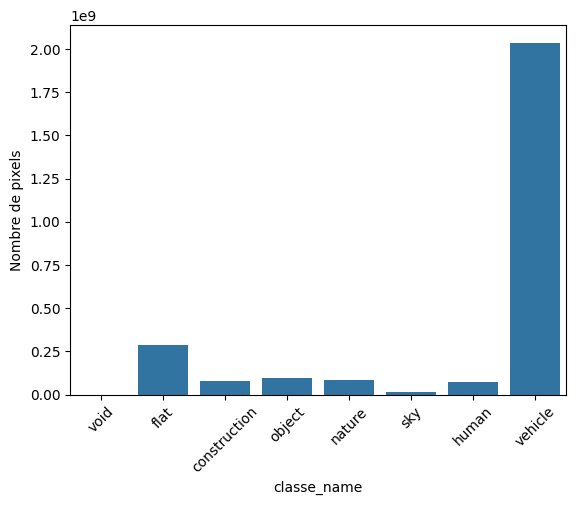

In [15]:
sns.barplot(df_class_count, x="classe_name", y="Nombre de pixels")
plt.xticks(rotation=45)
plt.show()

# VI - Entraînements 

In [16]:
def grid_train(name_run, model, loss, metrics, epochs, augment):
    runs = mlflow.search_runs(filter_string=f"tags.mlflow.runName='{name_run}'").index
    if len(runs) == 0:
        train_sequence = ImageMaskGenerator(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, id2catid, batch_size=BATCH_SIZE, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, augment=augment, limit_num_images=LIMIT_NUM_IMAGES)
        val_sequence = ImageMaskGenerator(VAL_IMAGE_DIR, VAL_MASK_DIR, id2catid, batch_size=BATCH_SIZE, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, shuffle=False, limit_num_images=LIMIT_NUM_IMAGES)
        model = nw["model"]((IMG_HEIGHT, IMG_WIDTH, 3))
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        with mlflow.start_run(run_name=name_run):
            model.fit(train_sequence, validation_data=val_sequence, epochs=epochs, batch_size=BATCH_SIZE)

neurals_networks = [
    {"name": "unet_mini", "model": unet_mini}, 
    {"name": "unet_vgg16", "model": unet_vgg16}
] 
params_loss = [{"name":"categorical_crossentropy", "loss":"categorical_crossentropy"}, {"name":"dice_loss", "loss":dice_loss_multiclass},{"name":"total_loss", "loss":total_loss}]
optimizer = "adam"
metrics = ["accuracy", iou_multi_class, dice_coefficient_multi_class]
epochs = 5

for nw in neurals_networks:
    for param in params_loss:
        name_run = f"{nw["name"]} with {param["name"]} {IMG_HEIGHT} * {IMG_WIDTH}"
        grid_train(name_run, nw["model"], param["loss"], metrics, epochs, augment=False)
        
        name_run = f"{nw["name"]} Augmented with {param["name"]} {IMG_HEIGHT} * {IMG_WIDTH}"
        grid_train(name_run, nw["model"], param["loss"], metrics, epochs, augment=True)

# VII - Analyses des meilleurs modèles

In [17]:
# Récupérer les runs sous forme de DataFrame

display_informations = ["run_id", "tags.mlflow.runName", "metrics.accuracy", "metrics.dice_coefficient_multi_class", "metrics.iou_multi_class", "metrics.val_accuracy", "metrics.val_dice_coefficient_multi_class", "metrics.val_iou_multi_class"]

# Afficher les 5 meilleurs runs pour l'accuracy
print("les meilleurs accuracy")
accuracy_runs = mlflow.search_runs(order_by=["metrics.accuracy DESC"], max_results=5)
df_best_accuracy = pd.DataFrame(accuracy_runs[display_informations])
display(df_best_accuracy)

# Afficher les 5 meilleurs runs pour le dice coefficient
print("les meilleurs dice coefficients")
dice_runs = mlflow.search_runs(order_by=["metrics.dice_coefficient DESC"], max_results=5)
df_best_dice_coefficient = pd.DataFrame(dice_runs[display_informations])
display(df_best_dice_coefficient)

# Afficher les 5 meilleurs runs pour le iou_multi_class
print("les meilleurs iou_multi_class")
iou_runs = mlflow.search_runs(order_by=["metrics.iou_multi_class DESC"], max_results=5)
df_best_iou = pd.DataFrame(iou_runs[display_informations])
display(df_best_iou)

les meilleurs accuracy


,run_id,tags.mlflow.runName,metrics.accuracy,metrics.dice_coefficient_multi_class,metrics.iou_multi_class,metrics.val_accuracy,metrics.val_dice_coefficient_multi_class,metrics.val_iou_multi_class
0,62109d7560ec4239a346f843a4301ecb,unet_vgg16 with total_loss 256 * 256,0.875469,0.091758,0.061050,0.858596,0.093674,0.062521
1,6448811715264587b2bede34fc0f3101,unet_vgg16 with categorical_crossentropy 256 *...,0.871561,0.091532,0.061040,0.856673,0.093504,0.062379
2,091e1a5ec0754aa3935d74b1b7148ea9,unet_vgg16 with categorical_crossentropy,0.855010,0.097705,0.060976,0.839997,0.092568,0.061936
3,6c3ffec6caf5440dba3fb07fe603548b,unet_vgg16 with dice_loss 256 * 256,0.840479,0.346984,0.066037,0.828994,0.347137,0.065431
4,d546ed7f5a354ecfa91a73bbb7accbba,unet_mini with total_loss 256 * 256,0.807305,0.090635,0.061042,0.795100,0.089898,0.059818


les meilleurs dice coefficients


,run_id,tags.mlflow.runName,metrics.accuracy,metrics.dice_coefficient_multi_class,metrics.iou_multi_class,metrics.val_accuracy,metrics.val_dice_coefficient_multi_class,metrics.val_iou_multi_class
0,04af52e006ee45c69e3e1e0895f84a00,unet_vgg16 Augmented with total_loss 256 * 256,0.792241,0.090195,0.061094,0.845278,0.090328,0.060761
1,ccc3f8e896944e8880304350c84a5cf8,unet_vgg16 Augmented with dice_loss 256 * 256,0.643903,0.255910,0.060091,0.656910,0.339686,0.060618
2,d546ed7f5a354ecfa91a73bbb7accbba,unet_mini with total_loss 256 * 256,0.807305,0.090635,0.061042,0.795100,0.089898,0.059818
3,1459b41d233d40f4b5ccac5c9d0a203a,unet_mini with dice_loss 256 * 256,0.707358,0.463953,0.060304,0.697540,0.465316,0.060244
4,4ba5a7fb1d744fc1b0810a5b4ee6817b,unet_mini with categorical_crossentropy 256 * 256,0.795607,0.251864,0.061530,0.794677,0.108236,0.061665


les meilleurs iou_multi_class


,run_id,tags.mlflow.runName,metrics.accuracy,metrics.dice_coefficient_multi_class,metrics.iou_multi_class,metrics.val_accuracy,metrics.val_dice_coefficient_multi_class,metrics.val_iou_multi_class
0,cb86f3121b894a37a1e3bfda5c213cd7,unet_mini Augmented with dice_loss 256 * 256,0.584865,0.123691,0.083492,0.717148,0.086149,0.055093
1,1623d896710f48498a47c3141e07d3ff,unet_mini Augmented with categorical_crossentr...,0.674768,0.349437,0.072201,0.762638,0.343991,0.065669
2,3b744af15b9d4fc8b65639b448c4b8b2,unet_mini Augmented with total_loss 256 * 256,0.674799,0.105432,0.071718,0.771493,0.091030,0.061539
3,54fb37de80a948c9bb1c443a3f67d879,unet_mini Augmented with categorical_crossentropy,0.684314,0.345502,0.070300,0.752978,0.297604,0.056308
4,6c3ffec6caf5440dba3fb07fe603548b,unet_vgg16 with dice_loss 256 * 256,0.840479,0.346984,0.066037,0.828994,0.347137,0.065431
